In [1]:
import warnings

warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind, wilcoxon, ranksums

In [2]:
K = 6
D = 10
N = 85
num_subjs = 92
num_resamples = 100
M=20
dir='/media/joyneelm/joy_backup/slds/moving_circles/bootstrap_resamples/'

In [3]:
from sklearn.cluster import KMeans
from munkres import Munkres
from sklearn.metrics.pairwise import cosine_similarity

def reference_comms(num_states, X):
    X = np.concatenate(X, axis=-1)
    print(X.shape)
    kmeans = KMeans(
        n_clusters=num_states, 
        init='k-means++', n_init=50,
        random_state=74
    ).fit(X=X.T)
    print('found reference')
    return kmeans.cluster_centers_.T # num_rois x num_comms

def align_two_partitions(source_comms, target_comms):
    # align source onto target
    
    # distatnce matrix
    Dd = 1 - cosine_similarity(target_comms.T, source_comms.T)
    # Hungarian permutation method
    best_pi = list(zip(*Munkres().compute(Dd)))[1]
    source_comms = source_comms[:, best_pi]
    return source_comms, best_pi

def align_partitions(num_states, X):
    comm_cntrs = reference_comms(num_states, X)
    print(comm_cntrs.shape)
    best_pis = []
    for idx, comms in tqdm(enumerate(X)):
        _, best_pi = align_two_partitions(
            source_comms=comms, 
            target_comms=comm_cntrs
        )
        best_pis.append(best_pi)
    return best_pis

def get_attractors(idx_resample):
    with open(f'{dir}/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
        model,_,_,_ = pickle.load(f)
    As = model.dynamics.As
    bs = model.dynamics.bs
    C = model.emissions.Cs[0]
    d = model.emissions.ds[0]
    attractors = np.zeros((K,N))
    for k in range(K):
        attractors[k,:] = C@(np.linalg.inv(np.eye(D)-As[k])@bs[k])+d
    attractors /= np.expand_dims(np.linalg.norm(attractors,axis=1),axis=1)
    return attractors.T

all_attractors = []    
for idx_resample in tqdm(range(1,1+num_resamples)):
    all_attractors.append(get_attractors(idx_resample))
print(all_attractors[0].shape)

all_perms = align_partitions(K,all_attractors)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [14:42<00:00,  8.82s/it]


(85, 6)
(85, 600)
found reference
(85, 6)


100it [00:00, 897.37it/s]


In [4]:
with open('pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

In [5]:
def get_attractor(model):
    attractors = np.zeros((K,D))
    for idx_state in range(K):
        A = model.dynamics.As[idx_state]
        b = model.dynamics.bs[idx_state]
        attractor = np.linalg.inv(np.eye(D)-A) @ b
        attractors[idx_state,:] = attractor
    return attractors

def get_centroid(df):
    zs = np.hstack(list(df['discrete_states'].values))
    xs = np.vstack(list(df['continuous_states'].values))
    centroids = np.zeros((K,D))
    for k in range(K):
        centroids[k,:] = np.mean(xs[zs==k,:],axis=0)
    return centroids

def cosine(v1,v2):
    return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

def get_df(idx_resample,perm):
    with open(f'{dir}/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
        model,q,elbos,resampled_subj_list = pickle.load(f)
    
    model.permute(perm)
    model.permute(np.array([1,2,4,3,5,0]))
    
    attractors = get_attractor(model)

    resampled_df = []
    for pid in resampled_subj_list:
        resampled_df.append(orig_df[orig_df['pid']==pid])
    resampled_df = pd.concat(resampled_df).reset_index().drop('index',axis=1)
    df = resampled_df

    df['continuous_states'] = [None]*df.shape[0]
    df['discrete_states'] =[None]*df.shape[0]
    df['stim'] =[None]*df.shape[0]
    df['sims'] =[None]*df.shape[0]
    hrflag=0
    prox_bins = list(np.arange(M//2)/(M//2))[1:]
    dir_bins = [0]
    nprox = len(prox_bins)+1
    ndir = len(dir_bins)+1
    for idx_row in range(df.shape[0]):
        prox = df.loc[idx_row]['proximity']
        prox = prox - prox.min()
        prox = prox / prox.max()
        proxd = np.digitize(prox, bins=prox_bins)
        dird = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)
        stim_category = (nprox*ndir-1)*dird+((-1)**dird)*proxd
        df.at[idx_row,'stim'] = stim_category
        input = np.roll(np.eye(nprox*ndir)[stim_category],shift=hrflag,axis=0)

        y = df.loc[idx_row]['timeseries']
        x = q.mean_continuous_states[idx_row]
        z = model.most_likely_states(x,y,input=input)
        df.at[idx_row,'continuous_states'] = x
        df.at[idx_row,'discrete_states'] = z
        prox = df.loc[idx_row]['proximity']
        prox = prox - prox.min()
        prox = prox / prox.max()
        df.at[idx_row,'proximity'] = prox

    centroids = get_centroid(df)

    for idx_row in range(df.shape[0]):
        zs = df.loc[idx_row]['discrete_states'].copy()
        xs = df.loc[idx_row]['continuous_states'].copy()
        stim_categories = df.loc[idx_row]['stim'].copy()
        hrf_shift = 3
        # zs = zs[hrf_shift:]
        # xs = xs[hrf_shift:,:]
        # stim_categories = np.roll(stim_categories,shift=hrf_shift)#[hrf_shift:]
        sims = np.zeros((len(zs),K))
        for t in range(len(zs)):
            for k in range(K):
                x = xs[t]
                z = zs[t]
                stim = stim_categories[t]
                dx = centroids[k]-x
                v = model.dynamics.Vs[z][:,stim]
                sim = cosine(dx,v)
                sims[t,k] = sim
        df.at[idx_row,'sims'] = np.roll(sims,hrf_shift,axis=0)

    return df,model

In [6]:
all_dfs = {}
all_models = {}
for idx_resample in tqdm(range(1,num_resamples+1)):
    all_dfs[idx_resample],all_models[idx_resample] = get_df(idx_resample,np.array(all_perms[idx_resample-1]))

100%|██████████| 100/100 [40:12<00:00, 24.12s/it]


In [7]:
winlen = 8
trans_list = ['02','24','43','32','21','10','03','34']

def get_transition_responses(y,z,st_i,st_j,win=winlen):
    ret = []
    for t in range(win//2-1,len(z)-win//2):
        if z[t]==st_i and z[t+1]==st_j:
            if np.all(z[t-win//2+1:t+1]==st_i) and np.all(z[t+1:t+win//2+1]==st_j):
                ret.append(y[t-win//2+1:t+win//2+1])
    if len(ret)>0: return np.mean(np.stack(ret,axis=0),axis=0)
    else: return None

def bootstrap_err(sample):
    means = np.zeros(100)
    for i in range(100):
        means[i] = np.random.choice(sample,len(sample),replace=True).mean()
    return means.std()*1.96
def bootstrap_err_matrix(X):
    ret = np.zeros_like(X[0])
    for i in range(X[0].shape[0]):
        for j in range(X[0].shape[1]):
            ret[i,j] = bootstrap_err(X[:,i,j])
    return ret

def get_mean_transition_response(df,state_from,state_to):
    subj_list = df.pid.unique()
    trans_responses = []
    for pid in subj_list:
        count = 0
        df_subj = df[df.pid==pid]
        z_subj = np.hstack(list(df_subj.discrete_states.values))
        y_subj = np.vstack(list(df_subj['sims'].values))
        y_trans = get_transition_responses(y_subj,z_subj,state_from,state_to)
        if y_trans is not None: trans_responses.append(y_trans)
    trans_responses = np.stack(trans_responses,axis=0)
    mean_trans_response = trans_responses.mean(axis=0)
    std_trans_response = bootstrap_err_matrix(trans_responses)
    return mean_trans_response,std_trans_response

In [8]:
with open(f'pkl/state_masks_K{K}_D{D}_N{N}_{num_subjs}subjs.pkl','rb') as f:
    state_masks = pickle.load(f)
resp = {trans:[] for trans in trans_list}
for idx_resample in tqdm(range(1,num_resamples+1)):
    df = all_dfs[idx_resample]
    state_mask = state_masks[idx_resample]
    for i in range(K):
        for j in range(K):
            if state_mask[i]==1 or state_mask[j]==1: continue
            if f'{i}{j}' not in trans_list: continue
            mean_resp, _ = get_mean_transition_response(df,i,j)
            resp[f'{i}{j}'].append(mean_resp)

m = {trans:[] for trans in trans_list}
e = {trans:[] for trans in trans_list}
for trans in trans_list:
    print(len(resp[trans]))
    trans_responses = np.stack(resp[trans])
    m[trans] = np.mean(trans_responses,axis=0)
    e[trans] = bootstrap_err_matrix(trans_responses) #np.std(trans_responses,axis=0)

100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


48
44
48
44
55
55
51
48


In [9]:
state_names = [f'State{i+1}' for i in range(K)]
net_colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

def plot_line(ax,m,e,idx_roi,label,color):
    ax.plot(m[:,idx_roi],label=label,color=color)
    ax.scatter(np.arange(winlen),m[:,idx_roi],color=color,s=20)
    ax.fill_between(np.arange(winlen),m[:,idx_roi]-e[:,idx_roi],m[:,idx_roi]+e[:,idx_roi],alpha=0.2,color=color)
    ax.axvline(x=winlen//2-0.5,color='k',linestyle='-',linewidth=2)
    ax.axhline(y=0,color='k',linestyle='--',linewidth=2)

def plot_transitions(trans_list,color_list,nrows=3,ncols=3,figsize=(20,10)):
    label_list = [f'{state_names[int(i)//10]}$\mapsto${state_names[int(i)%10]}' for i in trans_list]
    fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize,sharex=True,sharey=False)
    for i,trans in enumerate(trans_list):
        if nrows>1: ax = axs[i//ncols][i%ncols]
        else: ax = axs[i%ncols]
        fr,to = int(trans[0]),int(trans[1])
        # print(m[trans].shape,e[trans].shape)
        for j in range(K-1):
            plot_line(ax,m[trans],e[trans],j,None,net_colors[j])
        ax.set_title(label_list[i], fontsize=20)
        if i/ncols==1 and i%ncols==0:
            ax.set_ylabel('Activity(a.u.)',fontsize=20)
            ax.yaxis.set_label_coords(-0.3,1.2)
        if nrows==1 or i//ncols==ncols-1: ax.set_xlabel('Time(TR)',fontsize=15)
        ax.set_xticks(np.arange(winlen))
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    fig.tight_layout(pad=0)
    return fig,axs

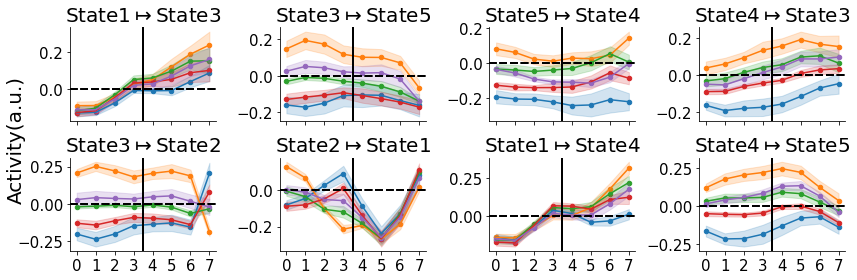

In [10]:
fig,axs = plot_transitions(trans_list,['black'],nrows=2,ncols=4,figsize=(12,4))
# fig.delaxes(axs[1][3])
# fig.delaxes(axs[1][2])
# fig.legend(fontsize=16,loc='right',bbox_to_anchor=(1.3, 0.5))
fig.tight_layout()